<a href="https://colab.research.google.com/github/yuriao/DataScienceProjects/blob/main/%5BICME_NLP%5D_Notebook_1_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Transformer from scratch

*Afshine Amidi, Shervine Amidi*

*Introduction to Natural Language Processing, Stanford ICME Summer workshop 2023*

## Introduction

In this section, we would like to check our understanding of the material that we went through in class. We want to build a Transformer from scratch using Keras, and use the model to translate English text to French.

Let's do this!

## Getting ready

Before starting, it is important to ensure that the relevant packages are properly installed. In order to do that, we use the `pip` command.

In [ ]:
!pip install tokenizers

Now, let's load the required libraries.

In [ ]:
from typing import Dict, List

import os
import numpy as np
import tarfile
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## Data retrieval

We will be using a dataset coming from the [European Parliament Proceedings Parallel Corpus](https://www.statmt.org/europarl/). Our goal will be to translate English text to French text.

First, we retrieve the dataset from the official website.

In [ ]:
!wget https://www.statmt.org/europarl/v7/fr-en.tgz

Then, we untar the data and preprocess it.


In [ ]:
# Specify source and target languages.
SOURCE_LANG, TARGET_LANG = 'en', 'fr'
TARGET_SOURCE = TARGET_LANG + '-' + SOURCE_LANG

In [ ]:
# Untar file.
tar = tarfile.open(TARGET_SOURCE + '.tgz', "r:gz")
tar.extractall()
tar.close()

In [ ]:
# Retrieve data.
with open('europarl-v7.' + TARGET_SOURCE + '.' + SOURCE_LANG) as f:
  lines_source = f.read().split("\n")[:-1]
with open('europarl-v7.' + TARGET_SOURCE + '.' + TARGET_LANG) as f:
  lines_target = f.read().split("\n")[:-1]

Let's look at some side-by-side translations.

In [ ]:
for sentence_index in range(15):
  source_sentence = lines_source[sentence_index]
  target_sentence = lines_target[sentence_index]

  print('Source: ', source_sentence)
  print('Target: ', target_sentence)

We see that there are very long sentences that may be good to remove for this demo. Also, some sentences are not real sentences (e.g. the lines that are in between parentheses).

## Tokenization

In this part, we are going to divide the text into indivisible entities that we are going to use in our model.

We are going to use a vanilla tokenizer that will separate entities that have a white space as well as punctuation. This vanilla method is often known as `WordLevel` -- i.e. it just takes space-separated words and punctation and maps them to an ID that the model will understand. For those who are curious about more advanced tokenization techniques: don't worry! We will see some of the most common ones in the second session.

In order to train our tokenizer, we use Hugging Face's `tokenizers` library as they make everything easier. We first import all relevant classes and functions:

In [ ]:
from tokenizers import Tokenizer
from tokenizers import models, normalizers, pre_tokenizers, decoders, trainers
from tokenizers.normalizers import Lowercase
from tokenizers.pre_tokenizers import Whitespace, Digits
from tokenizers.processors import TemplateProcessing

Then, we are going to filter our data like we hinted in the previous part in order to have an easier dataset to work with.

In [ ]:
# Parameters.
N_SEQ = 20

In [ ]:
def is_valid_sentence(sentence: str, n_max: int) -> bool:
  """Boolean indicating whether the provided sentence has a small enough size.

  Args:
    sentence: String that represents a sentence.
    n_max: Maximum number of words allowed.
  """
  return (len(sentence.split(' ')) < n_max) and (len(sentence.split(' ')) > 0)

def preprocess_data(sentences_source: List[str], sentences_target: List[str],
                    n_seq: int = N_SEQ, n_special_token: int = 2):
  """"Filters sentences that have a length that is less than a value.

  Args:
    sentences_souce: Sentence in the source language.
    sentences_target: Sentence in the target language.
    n_seq: Maximum length of the sequence.
    n_special_token: Number of beginning/end special tokens.
  """
  # Initialization.
  n_corpus = len(sentences_source)
  n_max = n_seq-n_special_token
  source_text_list = []
  target_text_list = []

  # Pick short sentences.
  for sentence_index in range(n_corpus):
    # Approximatively check if short enough.
    if (is_valid_sentence(sentences_source[sentence_index], n_max) and
          is_valid_sentence(sentences_target[sentence_index], n_max)):
        source_text = "[BOS] " + sentences_source[sentence_index] + " [EOS]"
        target_text = "[BOS] " + sentences_target[sentence_index] + " [EOS]"
        source_text_list.append(source_text)
        target_text_list.append(target_text)

  return source_text_list, target_text_list

In [ ]:
# Preprocess the data.
source_text_list, target_text_list = preprocess_data(lines_source, lines_target)

We also create a `split_data` function that stores the train, test and validation sets in a dictionary for ease of use.

In [ ]:
def split_data(source_text_list: List[str], target_text_list: List[str],
               n_val: int = 2000,
               n_test: int = 2000) -> Dict[str, Dict[str, List[str]]]:
  """Split data into train, validation and test, and store them in a dict.

  Args:
    source_text_list: List of sentences in the source language.
    target_text_list: List of sentences in the target language.
    n_val: Number of samples in the validation set.
    n_test: Number of samples in the testing set.
  """
  # Initialization.
  data_dict = {}
  lang_type_list = ['source', 'target']

  for lang_type in lang_type_list:
    # Create map for each language.
    data_dict[lang_type] = {}
    if lang_type == 'source':
      ref_list = source_text_list
    else:
      ref_list = target_text_list

    # Store train, val and test sets.
    data_dict[lang_type]['train'] = ref_list[:-(n_val+n_test)]
    data_dict[lang_type]['val'] = ref_list[-(n_val+n_test):-n_test]
    data_dict[lang_type]['test'] = ref_list[-n_test:]

  return data_dict

In [ ]:
# Split the data.
data_dict = split_data(source_text_list, target_text_list)

Now that we have a cleaner dataset, let's work on the tokenizer. We use our training set to train our tokenizer in order to find the relevant vocabulary that our model can rely on.

In [ ]:
# Parameters.
VOCAB_SIZE = 15000

In [ ]:
def get_tokenizer(list_sentences: List[str], vocab_size: int = VOCAB_SIZE,
                  n_seq: int = N_SEQ):
  """Build tokenizer using Hugging Face's tokenizers library.

  Args:
    list_sentences: List of sentences that will be fed to train the tokenizer.
    vocab_size: Size of the vocabulary.
    n_seq: The maximum length of a given sentence, i.e. truncate to that size if
      necessary.
  """
  # Initialize tokenizer.
  tokenizer = Tokenizer(models.WordLevel(unk_token="[UNK]"))

  # Pre-processing step.
  # We use white space as separator, and tokenize digits
  # separately.
  # E.g. "hello123" will become ["hello", "1", "2", "3"].
  tokenizer.pre_tokenizer = pre_tokenizers.Sequence([
      Whitespace(),
      Digits(individual_digits=True)
  ])

  # Normalization step.
  # We consider all letters to be lower case.
  tokenizer.normalizer = normalizers.Sequence([Lowercase()])

  # Using WordLevel algorithm (vanilla).
  # We add 4 special tokens: [PAD], [BOS], [EOS] and [UNK]
  # We note that as is, [PAD] will have an id of 0,
  # [BOS] 1, [EOS] 2, and [UNK] 3.
  trainer = trainers.WordLevelTrainer(
      vocab_size=vocab_size,
      special_tokens=["[PAD]", "[BOS]", "[EOS]", "[UNK]"],
  )

  # Train tokenizer on text.
  tokenizer.train_from_iterator(list_sentences, trainer)

  # Enable padding.
  tokenizer.enable_truncation(max_length=n_seq)
  tokenizer.enable_padding(length=n_seq)

  return tokenizer

Now, let's train a Tokenizer on the training set, by fixing a limit in the vocabulary size:

In [ ]:
# Train a tokenizer for source and target languages separately.
tokenizer_source = get_tokenizer(data_dict['source']['train'], VOCAB_SIZE, N_SEQ)
tokenizer_target = get_tokenizer(data_dict['target']['train'], VOCAB_SIZE, N_SEQ+1)

We can check the size of the vocabulary:

In [ ]:
tokenizer_source.get_vocab_size()

Let's now take a look at the mapping `string` to `integer` that our tokenizer produced.

In [ ]:
tokenizer_source.get_vocab()

In [ ]:
output = tokenizer_source.encode("[BOS] This teddy bear is cute [EOS]")
output.tokens

In [ ]:
output.ids

Now we are going to compute the tokenized-encoded versions of the train, test and validation sets, using the `tokenizer_source` and `tokenizer_target` object. In order to do this, we are going to define the following function:

In [ ]:
def get_encoded_tokenized_data(data_dict, data_set: str,
                               source_lang: str = SOURCE_LANG,
                               target_lang: str = TARGET_LANG):
  # Retrieve nicely formatted source and target data.
  source_list, target_list = [
    data_dict['source'][data_set], data_dict['target'][data_set]
  ]

  # Tokenize both source and target sentences.
  source_encoded = tokenizer_source.encode_batch(source_list)
  target_encoded = tokenizer_target.encode_batch(target_list)

  # Convert to numpy array (Keras-friendly).
  encoder_input = tf.convert_to_tensor(
      np.array([encoded.ids for encoded in source_encoded])
  )
  # Making sure that:
  # a. decoder_input has size n
  # b. decoder_output is shifted to the right
  decoder_input = tf.convert_to_tensor(
      np.array([encoded.ids[:-1] for encoded in target_encoded])
  )
  decoder_output = tf.convert_to_tensor(
      np.array([encoded.ids[1:] for encoded in target_encoded])
  )

  # Format result.
  result = {'encoder_inputs': encoder_input,
            'decoder_inputs': decoder_input}, decoder_output

  return result

In [ ]:
def make_keras_dataset(data, data_set: str, batch_size: int = 64):
  """Prepare Keras-friendly input."""
  # Retrieve encoded tokenized data.
  encoded_tokenized_data = get_encoded_tokenized_data(
      data_dict, data_set=data_set
  )

  # Create Keras Dataset.
  keras_dataset = tf.data.Dataset.from_tensor_slices(encoded_tokenized_data)

  # Set batch size.
  keras_dataset = keras_dataset.batch(batch_size)
  keras_dataset = keras_dataset.shuffle(512).prefetch(8).cache()

  return keras_dataset

In [ ]:
train_ds = make_keras_dataset(data_dict, data_set='train')
val_ds = make_keras_dataset(data_dict, data_set='val')
test_ds = make_keras_dataset(data_dict, data_set='test')

The `train_ds` and `val_ds` will be then fed to our Keras model.

## Building model

In this part, we will be building a Transformer from scratch using what we learned in class. We will be using the Keras library to do that.

For simplicity, we will be setting the number of stacked encoder and the number of stacked encoder / stacked decoder $N$ to 1.

### Components

#### Encoder

The encoder part is composed of:
- **self-attention layer** `enc_enc_attn` (also known as encoder-encoder attention) along with its associated **layer normalization** `enc_enc_norm`.
- **feed forward neural network** `ffnn` along with its associated **layer normalization** `ffnn_norm`.

Both sub-layers have an added dropout layer for regularization purposes.

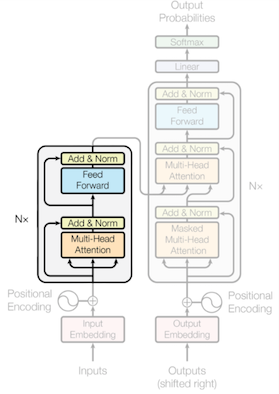

In [ ]:
class TransformerEncoder(layers.Layer):
  def __init__(self, n_heads: int, d_embed: int, d_key: int,
               d_ffnn: int, p_dropout: float, **kwargs) -> None:
    """Initializing Transformer Encoder.

    Args:
      n_heads: Number of heads in multi-head attention layer.
      d_embed: Dimension of the resulting embedding.
      d_key: Dimension of the key/query/value.
      d_ffnn: Dimension of projection within the feed forward neural network.
      p_dropout: Dropout rate in sub-layers.
    """
    # Inherit all properties from layers.Layer class.
    super(TransformerEncoder, self).__init__()

    # Hyperparameters.
    self.n_heads = n_heads
    self.d_embed = d_embed
    self.d_key = d_key
    self.d_ffnn = d_ffnn
    self.p_dropout = p_dropout

    # Self-attention layer.
    self.enc_enc_attn = layers.MultiHeadAttention(
      num_heads=self.n_heads, key_dim=self.d_key, use_bias=False,
      dropout=p_dropout)
    self.enc_enc_norm = layers.LayerNormalization()

    # Feed forward neural network.
    self.ffnn = keras.Sequential(
      [layers.Dense(units=self.d_ffnn, activation="relu"),
       layers.Dense(units=self.d_embed)]
    )
    self.ffnn_dropout = layers.Dropout(p_dropout)
    self.ffnn_norm = layers.LayerNormalization()

  def call(self, inputs):
    """Build Transformer Encoder with previously-defined layers.

    Args:
      inputs: Input sentence.
    """
    # Self-attention layer.
    enc_enc_attn_output = self.enc_enc_attn(query=inputs, key=inputs,
                                            value=inputs)
    enc_enc_norm_output = self.enc_enc_norm(inputs + enc_enc_attn_output)

    # Feed forward neural network.
    ffnn_output = self.ffnn(enc_enc_norm_output)
    ffnn_output = self.ffnn_dropout(ffnn_output)
    ffnn_norm_output = self.ffnn_norm(ffnn_output + enc_enc_norm_output)

    return ffnn_norm_output

  def get_config(self):
    """Function that is relevant to save the model."""
    config = super().get_config().copy()
    config.update({
        'n_heads': self.n_heads,
        'd_embed': self.d_embed,
        'd_key': self.d_key,
        'd_ffnn': self.d_ffnn,
        'p_dropout': self.p_dropout
    })
    return config

#### Decoder

The decoder part is composed of:
- **self-attention layer** `dec_dec_attn` (also known as decoder-decoder attention) along with its associated **layer normalization** `dec_dec_norm`
- **encoder-decoder attention layer** `enc_dec_attn` along with its associated **layer normalization** `enc_dec_norm`
- **feed forward neural network** `ffnn` along with its associated **layer normalization** `ffnn_norm`

All sub-layers have an added dropout layer for regularization purposes.

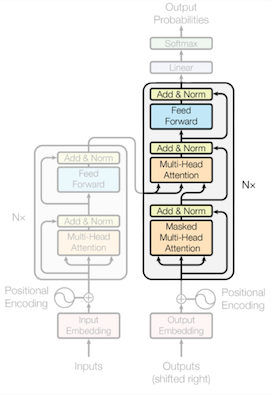

In [ ]:
class TransformerDecoder(layers.Layer):
  def __init__(self, n_heads: int, d_embed: int, d_key: int,
               d_ffnn: int, p_dropout: float, **kwargs) -> None:
    """Define Transformer Decoder layers using specified hyperparameters.

    Args:
      n_heads: Number of heads in multi-head attention layer.
      d_embed: Dimension of the resulting embedding.
      d_key: Dimension of the key/query/value.
      d_ffnn: Dimension of projection within the feed forward neural network.
      p_dropout: Dropout rate in sub-layers.
    """
    # Inherit all properties from layers.Layer class.
    super(TransformerDecoder, self).__init__()

    # Hyperparameters.
    self.n_heads = n_heads
    self.d_embed = d_embed
    self.d_key = d_key
    self.d_ffnn = d_ffnn
    self.p_dropout = p_dropout
    # Enables the mask to be passed to subsequent layers.
    self.supports_masking = True

    # Self-attention layer.
    self.dec_dec_attn = layers.MultiHeadAttention(
        num_heads=self.n_heads, key_dim=self.d_key, use_bias=False,
        dropout=p_dropout)
    self.dec_dec_norm = layers.LayerNormalization()

    # Encoder-decoder attention layer.
    self.enc_dec_attn = layers.MultiHeadAttention(
        num_heads=self.n_heads, key_dim=self.d_key, use_bias=False,
        dropout=p_dropout
    )
    self.enc_dec_norm = layers.LayerNormalization()

    # Feed forward neural network, where first layer has a ReLU
    # activation function.
    self.ffnn = keras.Sequential(
        [layers.Dense(units=self.d_ffnn, activation="relu"),
        layers.Dense(units=self.d_embed)])
    self.ffnn_dropout = layers.Dropout(p_dropout)
    self.ffnn_norm = layers.LayerNormalization()

  def call(self, output_shifted, enc_output):
    """Build Transformer Decoder with previously-defined layers.

    Args:
      output_shifted: Output shifted to the right, as indicated in the original
        paper.
      enc_output: Output exiting the encoder.
    """
    # Create causal mask.
    causal_mask = self._get_causal_attention_mask(output_shifted)

    # Self-attention layer.
    dec_dec_attn_output = self.dec_dec_attn(
        query=output_shifted,  key=output_shifted, value=output_shifted,
        attention_mask=causal_mask)
    dec_dec_norm_output = self.dec_dec_norm(output_shifted +
                                            dec_dec_attn_output)

    # Encoder-decoder attention layer.
    enc_dec_attn_output = self.enc_dec_attn(
        query=dec_dec_norm_output,
        value=enc_output,
        key=enc_output)
    enc_dec_norm_output = self.enc_dec_norm(dec_dec_norm_output +
                                            enc_dec_attn_output)

    # Feed forward neural network.
    ffnn_output = self.ffnn(enc_dec_norm_output)
    ffnn_output = self.ffnn_dropout(ffnn_output)
    ffnn_norm_output = self.ffnn_norm(ffnn_output + enc_dec_norm_output)

    return ffnn_norm_output

  def _get_causal_attention_mask(self, inputs):
      """Helper function to get the causal mask."""
      # Retrieve batch size and sequence length, known at run time.
      input_shape = tf.shape(inputs)
      batch_size, sequence_length = input_shape[0], input_shape[1]

      # Create mask where each token can only see itself and previous tokens.
      i = tf.range(sequence_length)[:, tf.newaxis]
      j = tf.range(sequence_length)
      mask = tf.cast(i >= j, dtype="int32")
      mask = tf.reshape(mask, (1, sequence_length, sequence_length))

      # Replicate the mask to cover all samples in the batch.
      mult = tf.concat(
          [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
          axis=0)

      return tf.tile(mask, mult)

  def get_config(self):
    """Function that is relevant to save the model."""
    config = super().get_config().copy()
    config.update({
        'n_heads': self.n_heads,
        'd_embed': self.d_embed,
        'd_key': self.d_key,
        'd_ffnn': self.d_ffnn,
        'p_dropout': self.p_dropout
    })
    return config

#### Embeddings

The embedding part is composed of:
- token embedding that is learnable
- position embedding that is learnable

In the original paper, experiments led to have it be either learned or fixed to be of a sinusoidal form

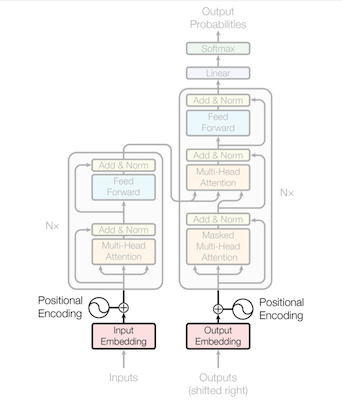

In [ ]:
class TransformerEmbedding(layers.Layer):
  def __init__(self, n_vocab: int, n_seq: int, d_embed: int, **kwargs) -> None:
    """Initializing Transformer Embeddings.

    Args:
      n_vocab: Number of tokens in vocabulary.
      n_seq: Number of maximmum tokens that can be taken into account in the
        input sequence.
      d_embed: Dimension of the resulting embedding.
    """
    # Inherit all properties from layers.Layer class.
    super(TransformerEmbedding, self).__init__()

    # Hyperparameters.
    self.n_vocab = n_vocab
    self.n_seq = n_seq
    self.d_embed = d_embed

    # Learnable token embedding.
    self.token_embedding = layers.Embedding(input_dim=self.n_vocab,
                                            output_dim=self.d_embed)

    # Learnable position embedding.
    self.position_embedding = layers.Embedding(input_dim=self.n_seq,
                                               output_dim=self.d_embed)

  def call(self, inputs):
    """Build Embedding layers.

    Args:
      inputs: Input sentence.
    """
    # Input-specific parameters.
    length = tf.shape(inputs)[-1]
    positions = tf.range(start=0, limit=length, delta=1)

    # Generate embeddings.
    token_embedding = self.token_embedding(inputs)
    position_embedding = self.position_embedding(positions)
    total_embedding = token_embedding + position_embedding

    return total_embedding

  def get_config(self):
    """Function that is relevant to save the model."""
    config = super().get_config().copy()
    config.update({
        'n_vocab': self.n_vocab,
        'n_seq': self.n_seq,
        'd_embed': self.d_embed
    })
    return config

### Stitching the pieces together

In [ ]:
class TranslationModel(layers.Layer):
  def __init__(self, n_vocab: int, n_seq: int, d_embed: int, d_key: int,
               n_heads: int, d_ffnn: int, p_dropout: float) -> None:
    # Inherit all properties from layers.Layer class.
    super(TranslationModel, self).__init__()

    # Hyperparameters.
    self.n_vocab = n_vocab
    self.n_seq = n_seq
    self.d_embed = d_embed
    self.d_key = d_key
    self.n_heads = n_heads
    self.d_ffnn = d_ffnn
    self.p_dropout = p_dropout

  def make_model(self):
    """Build Transformer model.

    Returns: The newly-built Transformer model.
    """
    # Encoder+Embedding part, built in isolation.
    encoder_inputs = keras.Input(shape=(None,), dtype="int32",
                                 name="encoder_inputs")
    input_tokens = TransformerEmbedding(
        n_vocab=self.n_vocab,
        n_seq=self.n_seq,
        d_embed=self.d_embed)(encoder_inputs)
    encoder_outputs = TransformerEncoder(
        n_heads=self.n_heads,
        d_embed=self.d_embed,
        d_key=self.d_key,
        d_ffnn=self.d_ffnn,
        p_dropout=self.p_dropout)(input_tokens)
    encoder = keras.Model(inputs=encoder_inputs, outputs=encoder_outputs,
                          name="EncoderWithEmbedding")

    # Decoder+Embedding part, built in isolation.
    decoder_inputs = keras.Input(
        shape=(None,), dtype="int32", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(
        shape=(None, d_embed), name="decoder_state_inputs")
    output_tokens = TransformerEmbedding(
        n_vocab=self.n_vocab, n_seq=self.n_seq, d_embed=self.d_embed
        )(decoder_inputs)
    decoder_outputs = TransformerDecoder(
        n_heads=self.n_heads, d_embed=self.d_embed, d_key=self.d_key,
        d_ffnn=self.d_ffnn, p_dropout=self.p_dropout
        )(output_tokens, encoded_seq_inputs)
    decoder_proba_outputs = layers.Dense(
        self.n_vocab, activation="softmax"
        )(decoder_outputs)
    decoder = keras.Model(
        inputs=[decoder_inputs, encoded_seq_inputs],
        outputs=decoder_proba_outputs,
        name="DecoderWithEmbedding")

    # Build Transformer model using the Encoder and Decoder parts.
    transformer_encoder_inputs = keras.Input(
        shape=(None,), dtype="int32", name="encoder_inputs")
    transformer_decoder_inputs = keras.Input(
        shape=(None,), dtype="int32", name="decoder_inputs")
    transformer_encoder_outputs = encoder(transformer_encoder_inputs)
    transformer_decoder_proba_outputs = decoder(
        [transformer_decoder_inputs, transformer_encoder_outputs])
    transformer = keras.Model(
        inputs=[transformer_encoder_inputs, transformer_decoder_inputs],
        outputs=transformer_decoder_proba_outputs, name="Transformer")

    return transformer

We specify desired hyperparameters below:

In [ ]:
d_embed = 256
d_key = 64
n_heads = 8
d_ffnn = 2048
p_dropout = 0.1

In [ ]:
transformer = TranslationModel(
    n_vocab=VOCAB_SIZE, n_seq=N_SEQ, d_embed=d_embed, d_key=d_key,
    n_heads=n_heads, d_ffnn=d_ffnn, p_dropout=p_dropout)
transformer = transformer.make_model()

In [ ]:
transformer.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [ ]:
transformer.summary()

### Visualize model

In [ ]:
keras.utils.plot_model(transformer)

## Training model

We use the pre-processed data obtained earlier in the notebook via the `data_dict` dictionary.

In [ ]:
nb_epochs = 6

transformer.fit(train_ds, epochs=nb_epochs, validation_data=val_ds)

## Load pre-trained model

In class, we won't have time to let the transformer train. In order to save time, we will load a transformer that we trained before the class (purely due to time constraints). The code below can be useful for you in case you would like to load a model that you pre-trained too.

In [ ]:
!pip install tensorflow_hub

In [ ]:
!wget https://stanford.edu/~shervine/transformer_translation_en-fr.hdf5

In [ ]:
# Enter file name.
file_name = 'transformer_translation_en-fr.hdf5'

In [ ]:
# Load a Keras model.
import tensorflow_hub as hub

transformer_loaded = tf.keras.models.load_model(file_name,
    custom_objects={
        'KerasLayer': hub.KerasLayer,
        'TransformerEmbedding': TransformerEmbedding,
        'TransformerEncoder': TransformerEncoder,
        'TransformerDecoder': TransformerDecoder
    }
)

## Misc. checks

### Check predictions

In this part, we will use the trained model to make some predictions on the test set.

In [ ]:
def decode_sequence(input_sentence, model,
                    max_decoded_sentence_length: int = 20):
  """Make a prediction on a given sentence."""
  # Tokenize input sentence.
  tokenized_input_sentence = tf.reshape(
    tf.convert_to_tensor(tokenizer_source.encode(input_sentence).ids), [1, -1]
  )

  # Initialize decoded sentence to [BOS].
  decoded_sentence = "[BOS]"

  for i in range(max_decoded_sentence_length):
      # Prepare decoder input.
      tokenized_target_sentence = tf.reshape(
          tf.convert_to_tensor(
            tokenizer_target.encode(decoded_sentence).ids[:-1]
          ), [1, -1]
      )

      # Make prediction.
      predictions = model([tokenized_input_sentence, tokenized_target_sentence])

      # Retrieve predicted word and add to decoded sentence.
      sampled_token_index = np.argmax(predictions[0, i, :])
      sampled_token = tokenizer_target.decode(
          [sampled_token_index], skip_special_tokens=False
      )
      decoded_sentence += " " + sampled_token

      # Stop if [EOS] is found.
      if sampled_token == "[EOS]":
          break

  return decoded_sentence

We make predictions on a few sentences in the test set and look if the predicted translations make sense:

In [ ]:
for sentence_index in range(10):
    # Sentence in the source language.
    input_sentence = data_dict['source']['test'][sentence_index]

    # Translation via the Transformer model.
    translated = decode_sequence(input_sentence, transformer_loaded)

    # Display results side by side.
    print('Input: ' + input_sentence)
    print('Prediction: ' + translated)

### Number of parameters

In this part, we will build various transformers having different hyperparameters and check our understanding about how many parameters these models have.

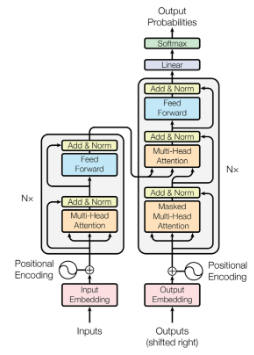

In [ ]:
transformer.summary()

In [ ]:
# Encoder + Embedding =
#   Token embedding +
#   Position embedding +
#   1 self-attention layer with {3 matrices per head + weight matrix} +
#   FFNN (without forgetting the bias!) +
#   2 layer normalizations
params_encoder_embed = \
  (VOCAB_SIZE * d_embed + \
  N_SEQ * d_embed + \
  4 * (d_embed * d_key * n_heads) + \
  (d_embed * d_ffnn + d_ffnn) + (d_ffnn * d_embed + d_embed) + \
  2 * (2 * d_embed))
print(params_encoder_embed)

In [ ]:
# Decoder + Embedding =
#   Token embedding +
#   Position embedding +
#   2 attention layer, each with {3 matrices per head + weight matrix} +
#   FFNN (without forgetting the bias!) +
#   3 layer normalizations +
#   Softmax layer (without forgetting the bias!)
params_decoder_embed = \
  VOCAB_SIZE * d_embed + \
  N_SEQ * d_embed + \
  2 * 4 * d_embed * d_key * n_heads + \
  (d_embed * d_ffnn + d_ffnn) + (d_ffnn * d_embed + d_embed) + \
  3 * (2 * d_embed) + \
  (d_embed + 1) * VOCAB_SIZE
print(params_decoder_embed)

## References

### Datasets
- Koehn et al., 2012. *Europarl: A Parallel Corpus for Statistical Machine Translation*. [statmt.org/europarl](https://www.statmt.org/europarl/).

### Posts
- HuggingFace, 2023. *Tokenizers*. [huggingface.co/docs/tokenizers/](https://huggingface.co/docs/tokenizers/).
- HuggingFace, 2023. *Transformers*. [huggingface.co/transformers/](https://huggingface.co/transformers/).
- Keras, 2023. *Dense layer*. [keras.io/api/layers/core_layers/dense/](https://keras.io/api/layers/core_layers/dense/).
- Keras, 2023. *Dropout layer*. [keras.io/api/layers/regularization_layers/dropout/](https://keras.io/api/layers/regularization_layers/dropout/).
- Keras, 2021. *English-to-Spanish translation with a sequence-to-sequence Transformer*. [keras.io/examples/nlp/neural_machine_translation_with_transformer/](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/).
- TensorFlow, 2023. *tf.data.Dataset*. [tensorflow.org/api_docs/python/tf/data/Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).
- TensorFlow, 2023. *tf.keras.layers.LayerNormalization*. [tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization).
- TensorFlow, 2023. *tf.keras.layers.MultiHeadAttention*. [tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention).
- TensorFlow, 2023. *Neural machine translation with a Transformer and Keras*. [tensorflow.org/text/tutorials/transformer](https://www.tensorflow.org/text/tutorials/transformer).

## Appendix

The code below shows how to save and load a Keras model.

In [ ]:
# File name.
file_name = 'transformer_translation_en-fr.hdf5'

In [ ]:
# Save a Keras model.
transformer.save(file_name)

In [ ]:
# Load a Keras model.
import tensorflow_hub as hub

from tensorflow import keras

transformer_loaded = tf.keras.models.load_model(file_name,
    custom_objects={
        'KerasLayer': hub.KerasLayer,
        'TransformerEmbedding': TransformerEmbedding,
        'TransformerEncoder': TransformerEncoder,
        'TransformerDecoder': TransformerDecoder
    }
)